In [1]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob

from pandeia.engine.calc_utils import build_default_calc, build_default_source
from pandeia.engine.perform_calculation import perform_calculation

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, lenstronomy_sim, pandeia_input, convert

In [2]:
bands = util.hydra_to_list(config.pipeline, 'band')

In [3]:
lens = SampleSkyPyLens()
model = lens.get_array(num_pix=97, side=10.67)

In [6]:
for band in bands:
    calc = build_default_calc('roman', 'wfi', 'imaging')
    calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.

    # set scene size settings
    calc['configuration']['max_scene_size'] = 20

    # set instrument
    calc['configuration']['instrument']['filter'] = band.lower()  # e.g. 'f106'

    # set detector
    calc['configuration']['detector']['ma_table_name'] = 'hlwas_imaging'

    # turn off noise sources
    calc['calculation'] = pandeia_input.get_calculation_dict(init=False)

    # add an extra point source far out to force maximum scene size
    calc['scene'].append(build_default_source(geometry='point', telescope='roman'))
    calc['scene'][1]['position']['x_offset'] = 100
    calc['scene'][1]['position']['y_offset'] = 100

    bkg, _ = pandeia_input.get_pandeia_image(calc)

    mjy_bkg = convert.counts_to_mjy(bkg, band.lower())

    np.save(os.path.join(repo_dir, 'mejiro', 'data', f'pandeia_bkg_minzodi_benchmark_{band.lower()}.npy'), mjy_bkg)

Performing Pandeia calculation...


Pandeia calculation complete in 0:00:06
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:07
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:08
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:06


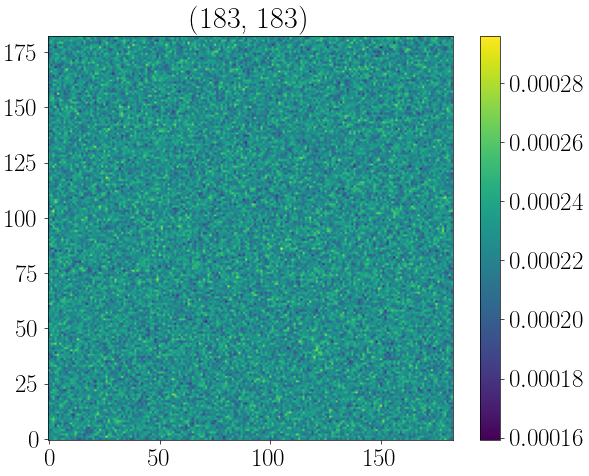

In [7]:
plot.plot(mjy_bkg, colorbar=True, title=f'{bkg.shape}')

In [8]:
bkg_list = []

for band in bands:
    bkg = np.load(os.path.join(repo_dir, 'mejiro', 'data', f'pandeia_bkg_minzodi_benchmark_{band.lower()}.npy'))

    bkg_cropped = util.center_crop_image(bkg, model.shape)

    flat = bkg_cropped.flatten()
    np.random.shuffle(flat)
    shuffled = flat.reshape(bkg_cropped.shape)

    bkg_list.append(shuffled)

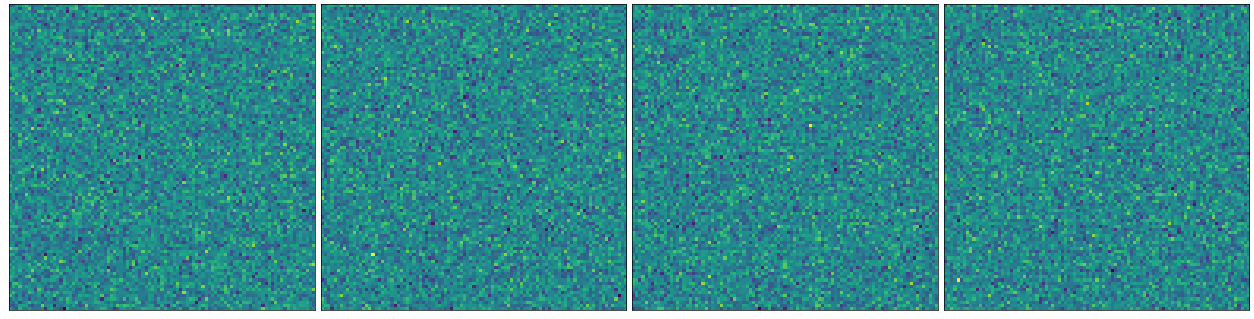

(97, 97)


In [12]:
plot.plot_list(bkg_list)
print(bkg_list[0].shape)

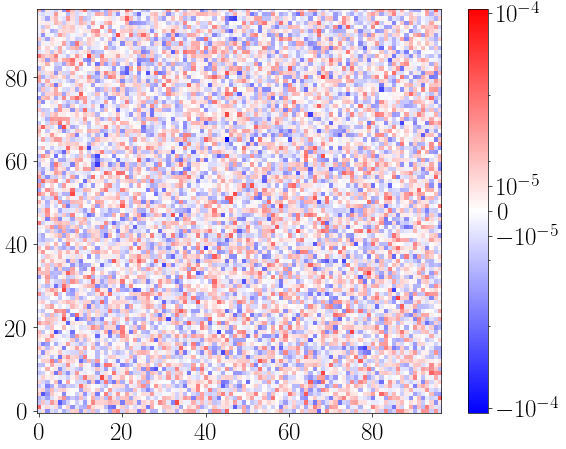

In [10]:
diagnostic_plot.residual(bkg_cropped, shuffled)